In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/Users/user/Jupyter/Orbit-Libraries/data/Steel_industry_data.csv')

In [5]:
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [6]:
print(data.columns)

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [15]:
data.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [17]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')

In [19]:
data['WeekStatus'] = data['WeekStatus'].map({'Weekday':1, 'Weekend':0})

In [21]:
le = LabelEncoder()
data['Day_of_week'] = le.fit_transform(data['Day_of_week'])

In [25]:
# Sorting data by date
data = data.sort_values('date').reset_index(drop=True)

<b> Exploratory Data Analysis </b>

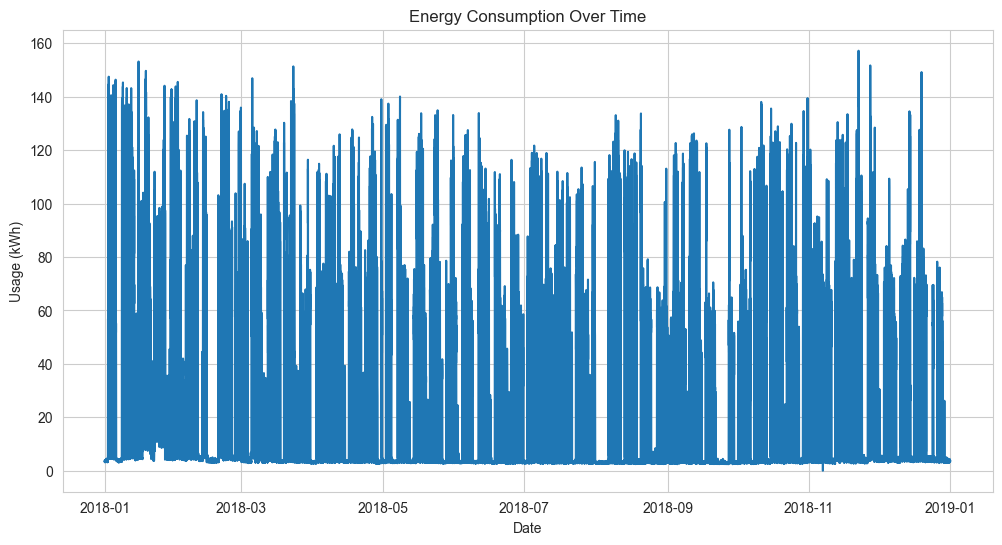

In [28]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['Usage_kWh'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.show()

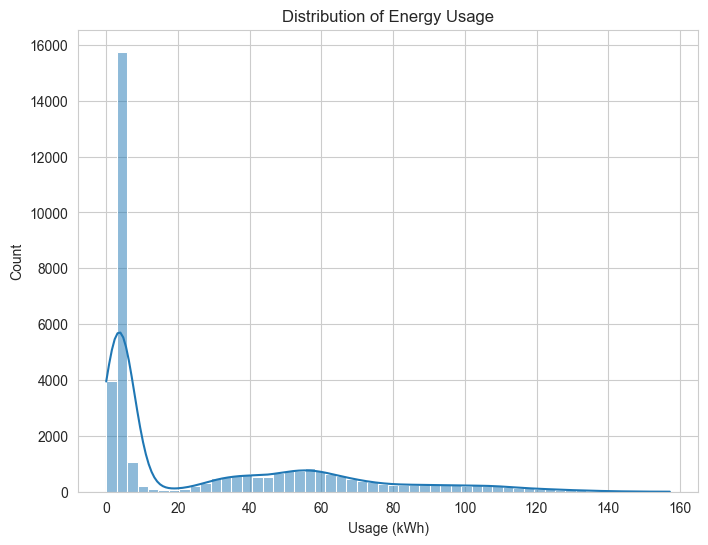

In [30]:
# Distribution of Usage_kWh
plt.figure(figsize=(8,6))
sns.histplot(data['Usage_kWh'], kde=True)
plt.title('Distribution of Energy Usage')
plt.xlabel('Usage (kWh)')
plt.show()

<b> Feature Engineering </b>

In [33]:
# Creating additional time feature
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [35]:
# Preparing Regressors
regressors = ['Lagging_Current_Reactive.Power_kVarh', 
              'Leading_Current_Reactive_Power_kVarh', 
              'CO2(tCO2)', 
              'Lagging_Current_Power_Factor', 
              'Leading_Current_Power_Factor', 
              'NSM', 
              'WeekStatus', 
              'Day_of_week',
              'month',
              'day']

<b>Prepping Data for Orbit</b>

In [101]:
# Selecting necessary columns
# Prepare data for modeling
orbit_data = data[['date', 'Usage_kWh'] + regressors].rename(columns={'date':'date', 'Usage_kWh':'value'})

In [103]:
test_size = int(0.2 * len(orbit_data))

train_df = orbit_data[:-test_size].copy()  # Added .copy() to avoid chained assignment warnings
test_df = orbit_data[-test_size:].copy()

In [105]:
print(train_df.columns)
print(test_df.columns)

Index(['date', 'value', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'month', 'day'],
      dtype='object')
Index(['date', 'value', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'month', 'day'],
      dtype='object')


<b>Fourier Terms</b>

In [107]:
def create_fourier_terms(df, period, order, col_name='date'):
    time_in_seconds = (df[col_name] - df[col_name].min()).dt.total_seconds()
    cycles = 2 * np.pi * time_in_seconds / (86400 * period)  # 86400 seconds in a day
    for i in range(1, order + 1):
        df[f'sin_{period}_{i}'] = np.sin(i * cycles)
        df[f'cos_{period}_{i}'] = np.cos(i * cycles)
    return df

In [109]:
# monthly seasonality
train_df = create_fourier_terms(train_df, period=30, order=3)  # 30-day period, 3 harmonics
test_df = create_fourier_terms(test_df, period=30, order=3)

<b>Modelling with Orbit</b>

In [ ]:
# Using DLT Model from Orbit, Damped Local Trend
dlt = DLT(
    response_col='value',
    date_col='date',
    regressor_col=regressors,
    seasonality=7,
    seed=42,
    estimator='stan-map',
    num_warmup=100, 
    num_sample=50,
    chains=2
)

In [47]:
# Fit Model
dlt.fit(train_df)

In [49]:
# Predicting on test set
predictions = dlt.predict(test_df)

In [54]:
predictions.set_index(test_df.index, inplace=True)

<b>Model Evaluation</b>

In [57]:
# Calculating sMAPE
smape_value = smape(test_df['value'], predictions['prediction'])
print(f'sMAPE: {smape_value:.2f}%')

sMAPE: 1.96%


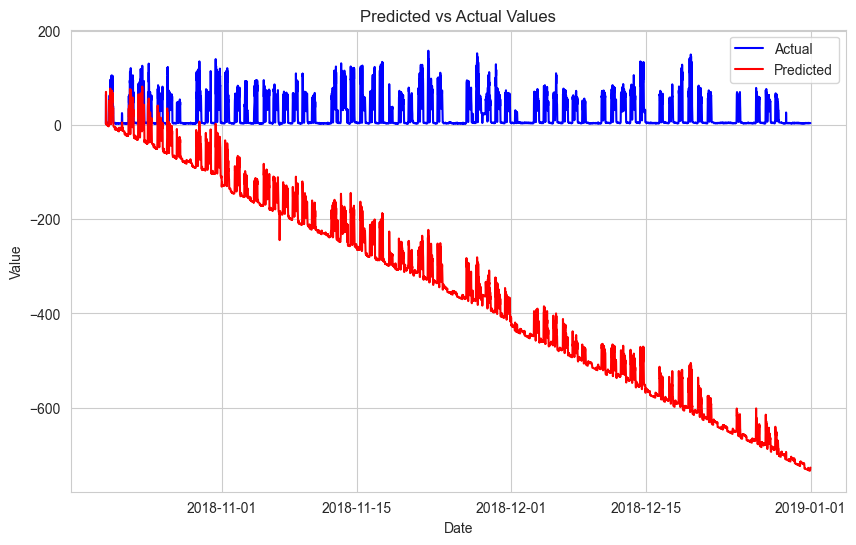

In [65]:
# Predicted vs Actual
plt.figure(figsize=(10, 6))

# actual
plt.plot(combined_df['date'], combined_df['value'], label='Actual', color='blue')

# predicted
plt.plot(combined_df['date'], combined_df['prediction'], label='Predicted', color='red')

# labels and titles
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values')

#legend
plt.legend()

plt.show()

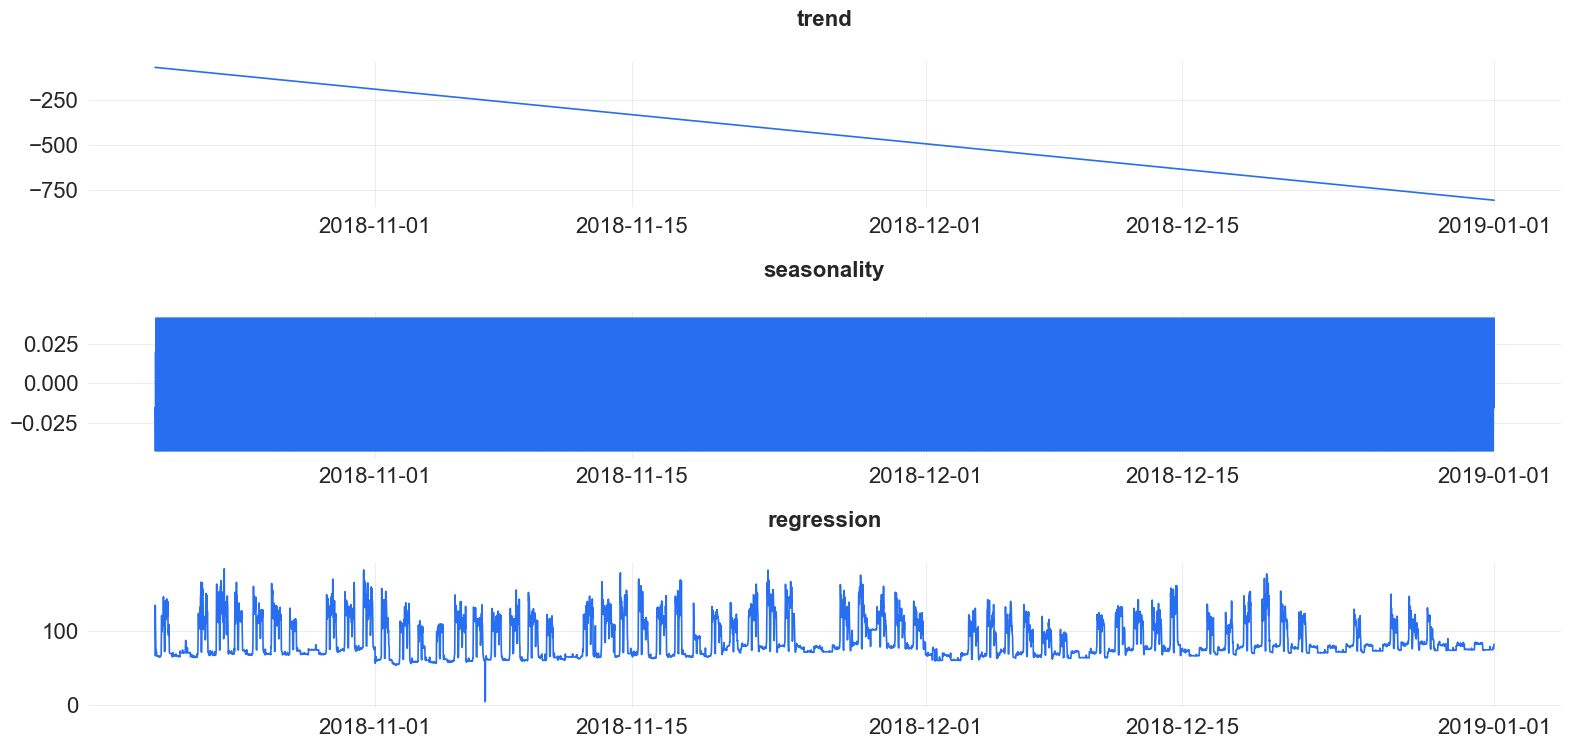

array([<Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [76]:
# predictions as a DataFrame
predicted_df = dlt.predict(test_df, decompose=True)

plot_predicted_components(
    predicted_df,
    date_col='date',
    is_visible=True
)

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_df['value'], predictions['prediction'])
rmse = np.sqrt(mean_squared_error(test_df['value'], predictions['prediction']))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 374.73
RMSE: 430.94


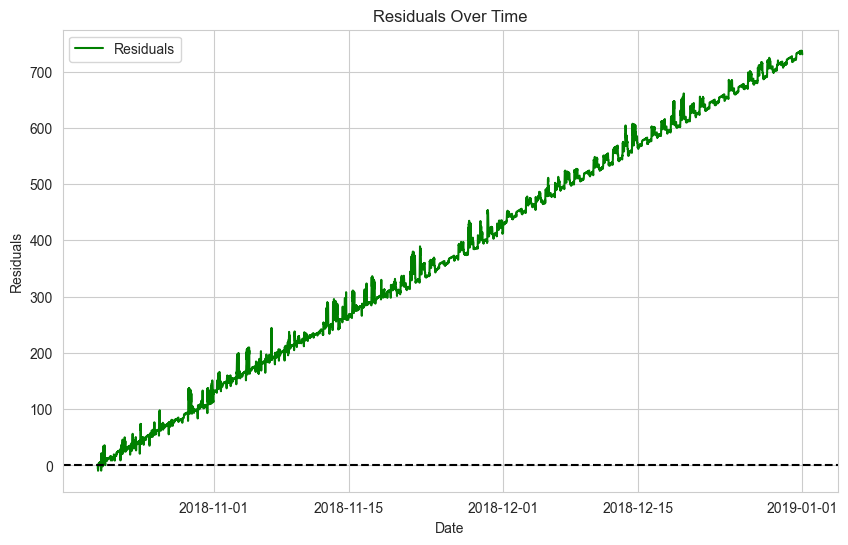

In [82]:
# Calculating residuals
combined_df['residuals'] = combined_df['value'] - combined_df['prediction']

# Ploting residuals
plt.figure(figsize=(10, 6))
plt.plot(combined_df['date'], combined_df['residuals'], label='Residuals', color='green')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()